In [222]:
# libraries
import os 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from sklearn.model_selection import GridSearchCV
import umap 


### Data

In [34]:
train_df = pd.read_csv('./dataset/train.csv')
train_df.shape

(1117957, 22)

In [35]:
test_df = pd.read_csv('./dataset/test.csv')
test_df.shape

(745305, 21)

### Explore data

In [36]:
train_df.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [38]:
# target variable 
min(train_df['FloodProbability'])

0.285

In [39]:
max(train_df['FloodProbability'])

0.725

<u> Notes: </u>

1. 21 columns and 1 target variable: `FloodProbability`
2. All variables are numeric
3. 1+ million rows 
4. No missing values

### Univariate analysis 

In [40]:
def plot_distribution(
        df: pd.DataFrame,
        variable: str
):
    """
    Plot histograms for specified variable while marking median, mean, lower and upper quartles

    """
    # descriptive stats 
    minimum = df[variable].min()
    maximum = df[variable].max()
    mean = df[variable].mean()
    median = df[variable].median()
    lower = np.percentile(df[variable], 25)
    upper = np.percentile(df[variable], 75)
    num_bins = int((max(df[variable]) - min(df[variable])) / 2)

    # histogram 
    plt.figure(figsize=(6,3))
    try:
        sns.histplot(data=df, x=variable, bins=num_bins)
    except:
        sns.histplot(data=df, x=variable)
    for k,v in {'mean':mean, 'median':median, 'lower':lower, 'upper':upper, 'min':minimum, 'max':maximum}.items():
        plt.axvline(x=v, color='black', linestyle='--')
        plt.text(v+0.02, 0, k, rotation=90, color='black')
    plt.title(variable, fontsize=8)
    plt.xlabel('')
    plt.xticks(fontsize=8)
    plt.ylabel('count', fontsize=8)
    plt.yticks(fontsize=8)
    ;


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_788/3510796814.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,3))


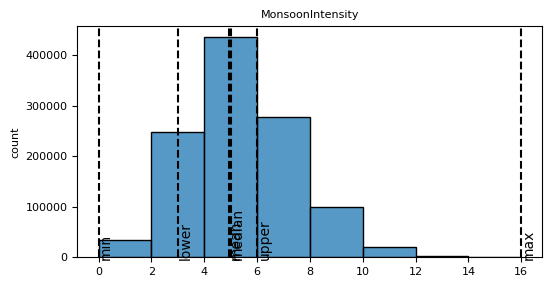

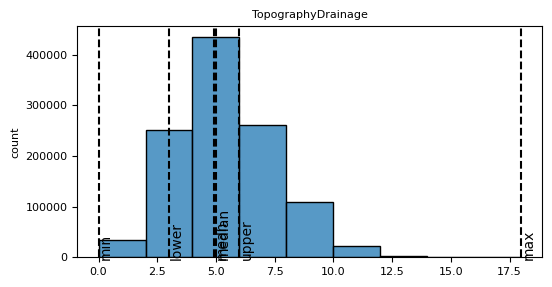

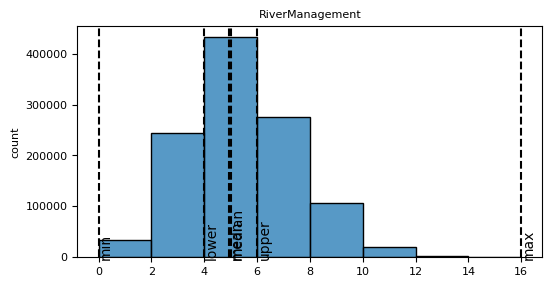

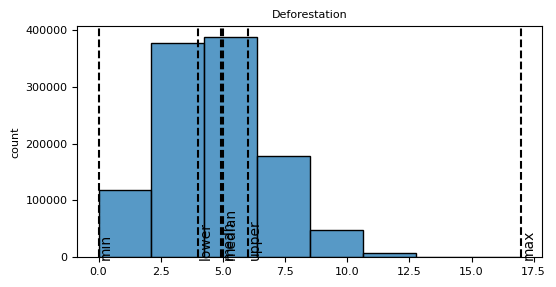

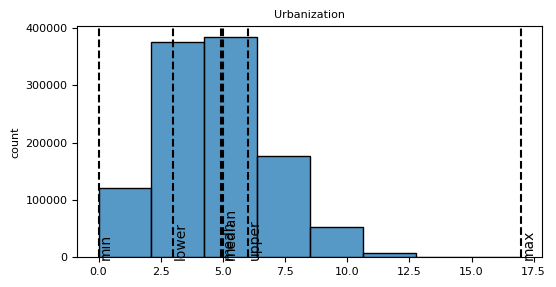

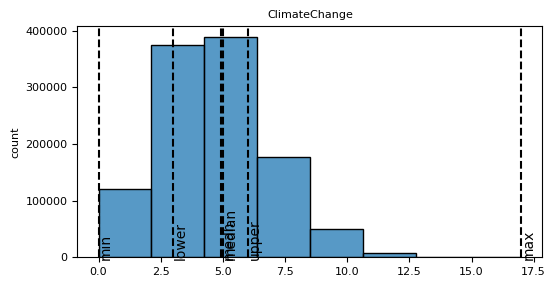

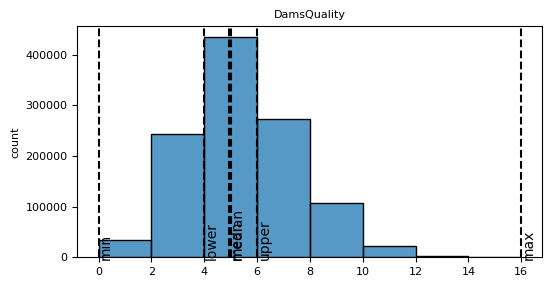

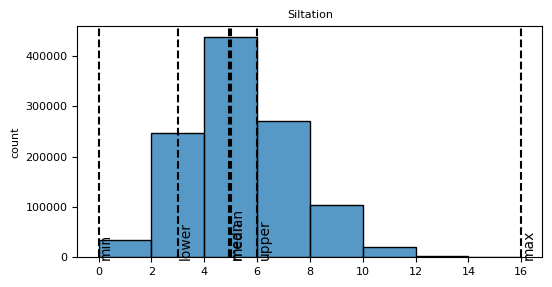

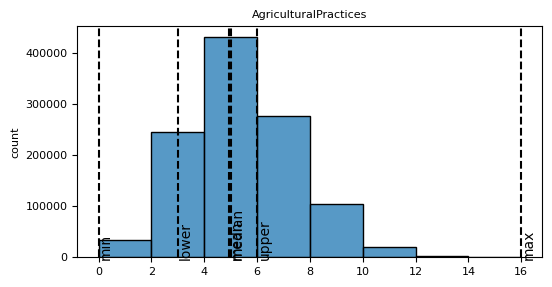

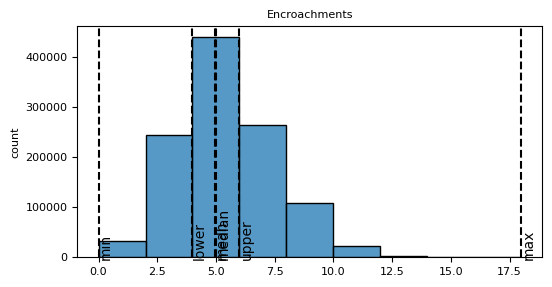

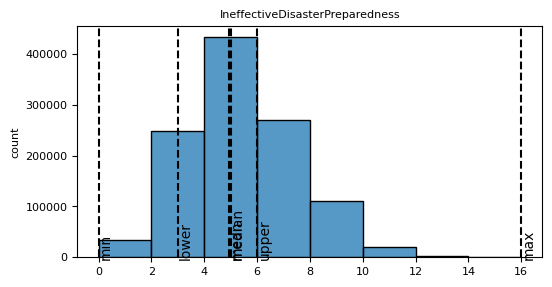

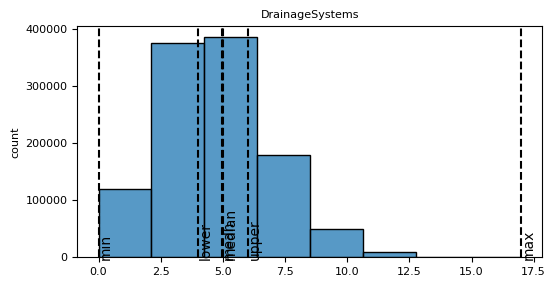

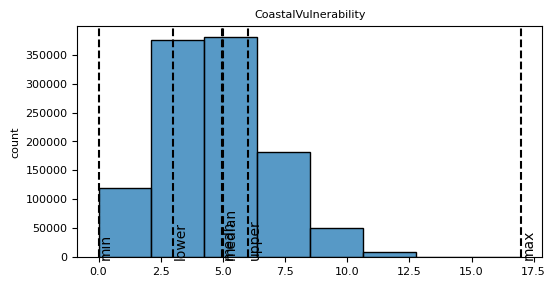

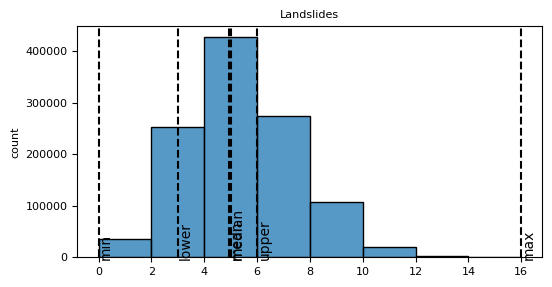

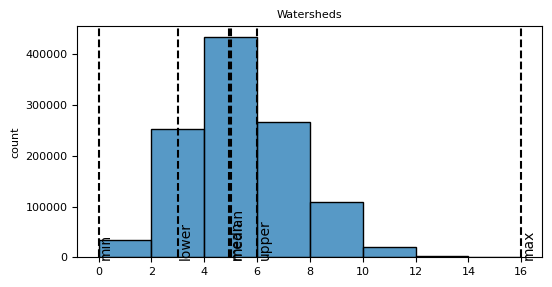

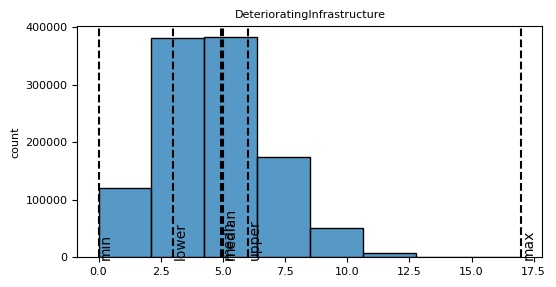

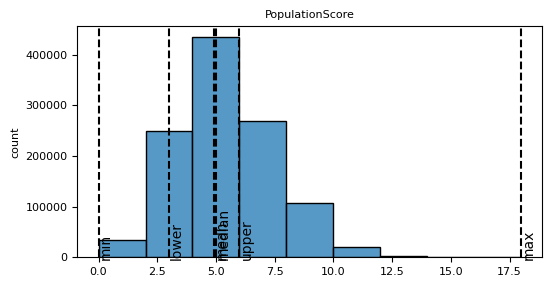

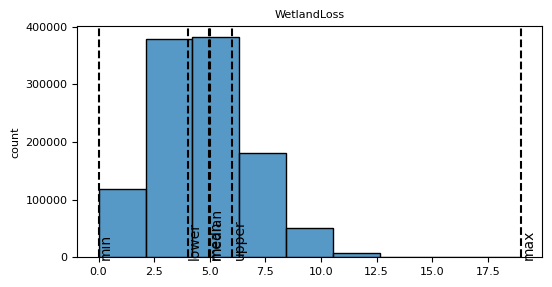

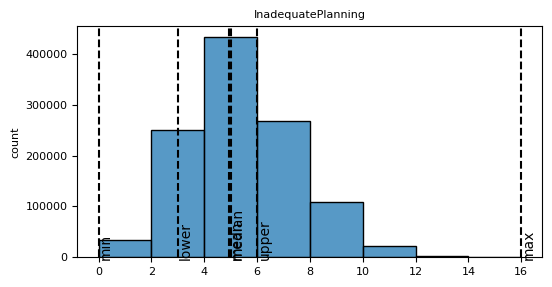

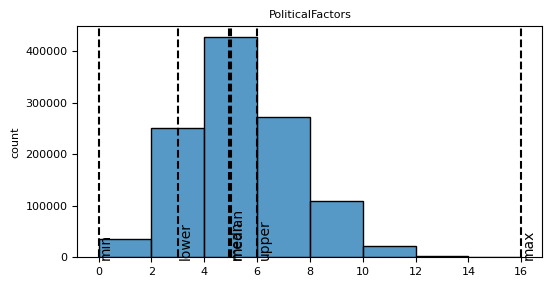

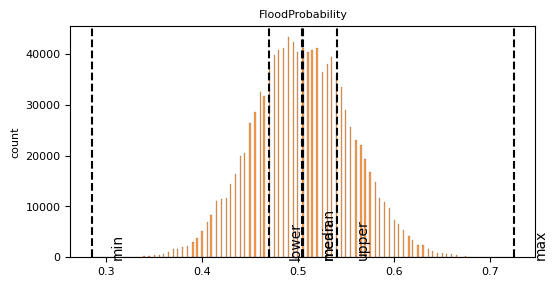

In [41]:
for i in train_df.columns:
    if train_df[i].nunique() == len(train_df):
        pass 
    else:
        plot_distribution(df=train_df, variable=i)

<u> Notes: </u>

1. Seems like most of the independent variables share similar mean and median values and are spread out relatively equally around the mean / median, i.e. bell-shaped distributions
2. There are also some outliers to the right (right skewed) but not extreme enough to pull the mean away from the center

### Bivariate analysis - between independent and target variable

In [42]:
def plot_correlation(
        df: pd.DataFrame,
        variable: str
):
    """
    Plot scatterplots for specified variable (x axis) against target variable (y axis) and 
    calculate Spearman's correlation coefficient

    """
    # prep table 
    target = 'FloodProbability'
    lowest = min(train_df['FloodProbability'])
    highest = max(train_df['FloodProbability'])
    plot_df = df.groupby(variable)[target].mean().to_frame().reset_index()

    # correlation 
    corr, pv = stats.spearmanr(df[variable], df[target])
    
    # plot 
    plt.figure(figsize=(6,3))
    sns.regplot(data=plot_df, x=variable, y=target)
    plt.title(f"Flood probability (mean) against {variable}", fontsize=8)
    plt.xlabel(f"{variable}", fontsize=8)
    plt.xticks(fontsize=8)
    plt.ylabel('Flood probability (mean)', fontsize=8)
    plt.yticks([round(i,2) for i in np.linspace(lowest, highest,10)], fontsize=8)
    plt.ylim(min(df[target]), max(df[target]))
    plt.text(max(df[variable]-2), 0.7, f"corr: {round(corr,2)}", color='black')
    ;
    

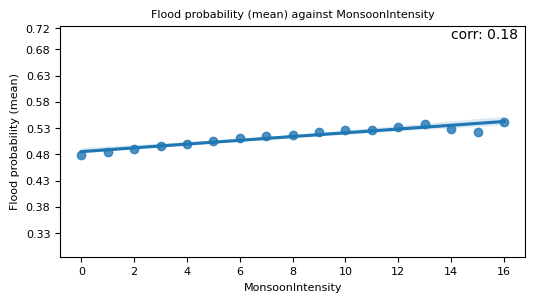

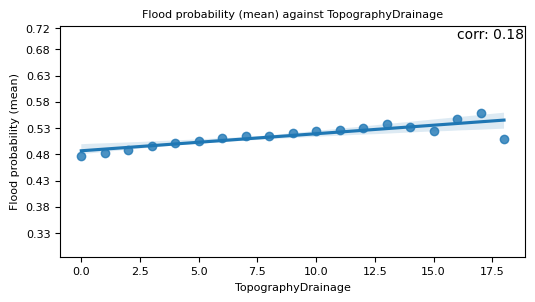

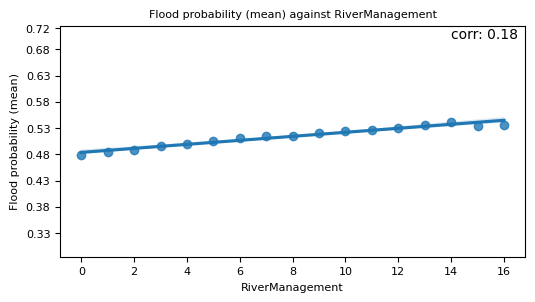

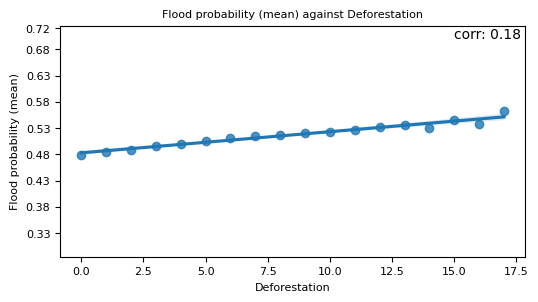

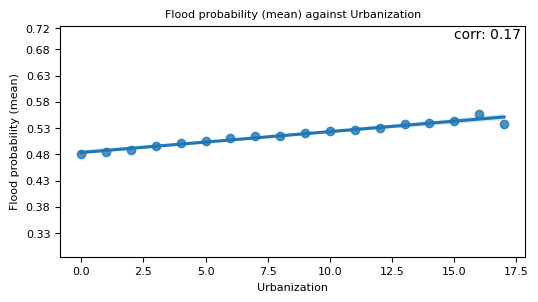

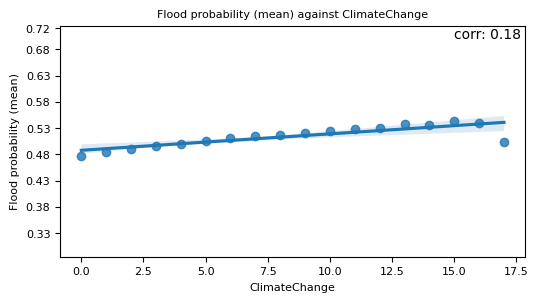

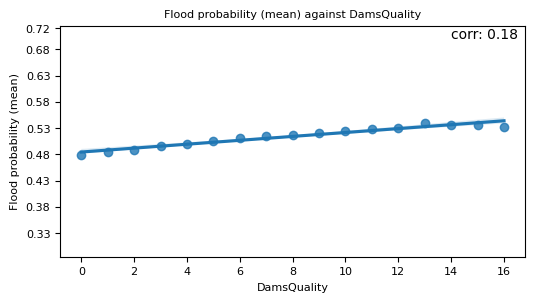

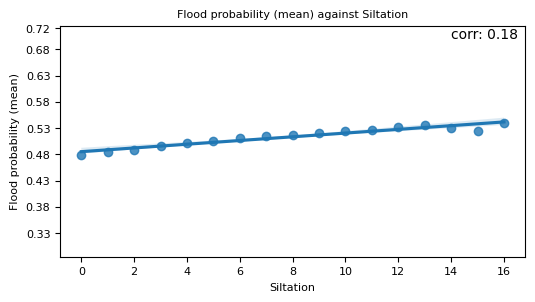

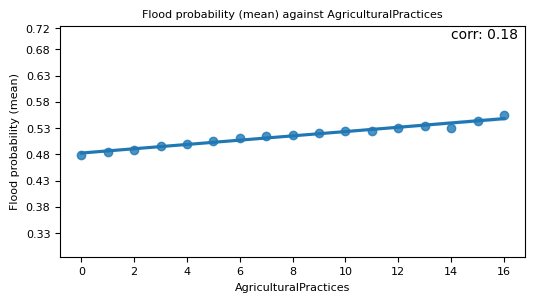

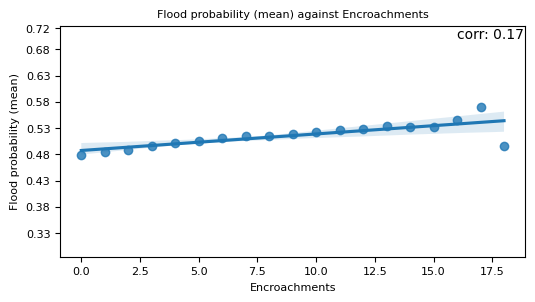

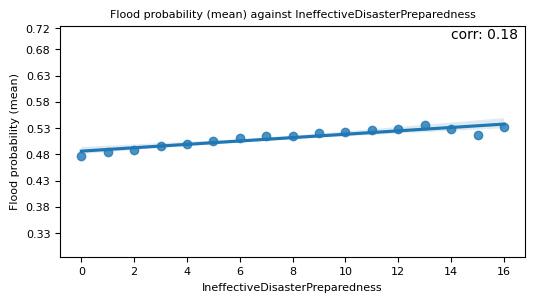

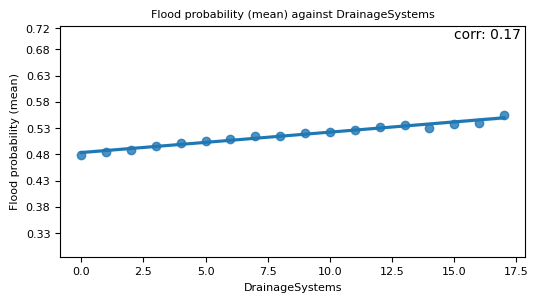

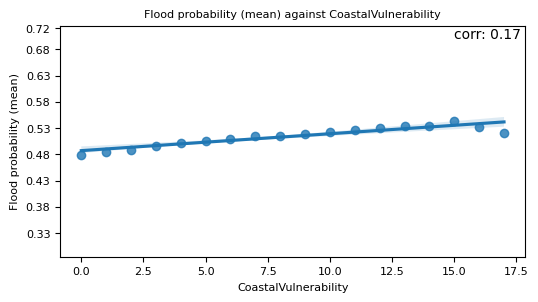

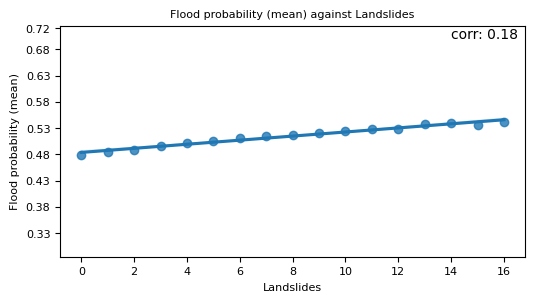

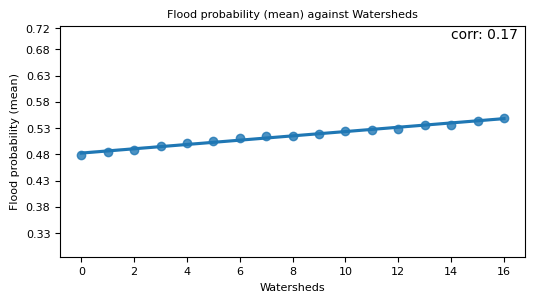

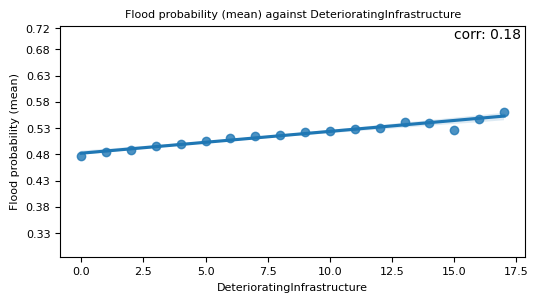

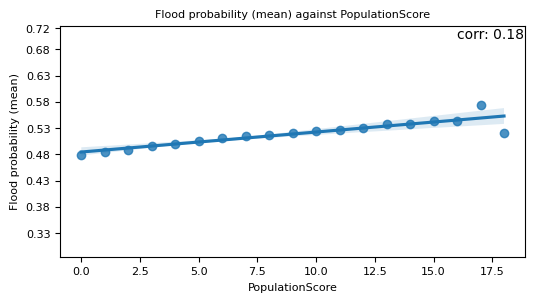

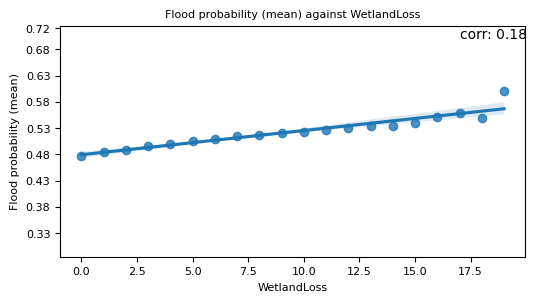

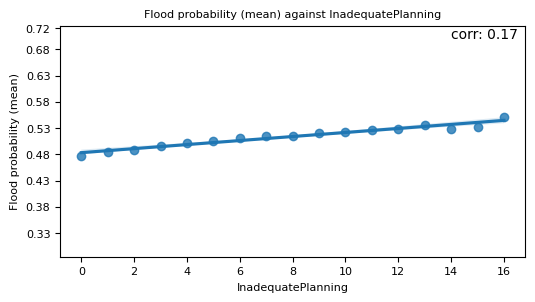

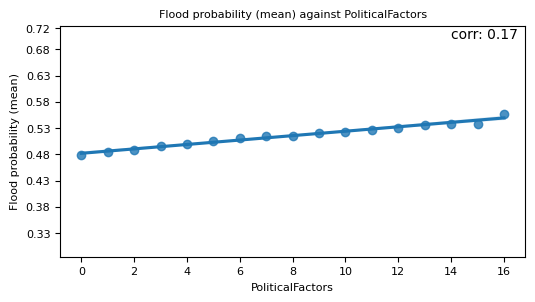

In [43]:
for i in train_df.columns:
    if i in ('id','FloodProbability'):
        pass 
    else:
        plot_correlation(df=train_df, variable=i)

<u> Notes: </u>

1. Seems like the strength of relationship between each independent and target variable are similar, at about + 0.17 / + 0.18
2. Correlations are quite poor for all pairings, at least when average flood probabilities is used

In [44]:
def plot_boxplots(
        df: pd.DataFrame,
        variable: str
):
    """
    Plot boxplots for specified variable (x axis) against target variable (y axis)

    """
    # prep table 
    target = 'FloodProbability'
    lowest = min(train_df['FloodProbability'])
    highest = max(train_df['FloodProbability'])
    
    # plot 
    plt.figure(figsize=(6,3))
    sns.boxplot(data=df, x=variable, y=target)
    plt.title(f"Distribution of flood probability against {variable}", fontsize=8)
    plt.xlabel(f"{variable}", fontsize=8)
    plt.xticks(fontsize=8)
    plt.ylabel('Flood probability (mean)', fontsize=8)
    plt.yticks([round(i,2) for i in np.linspace(lowest, highest, 10)], fontsize=8)
    plt.ylim(min(df[target]-0.05), max(df[target])+0.05)
    ;

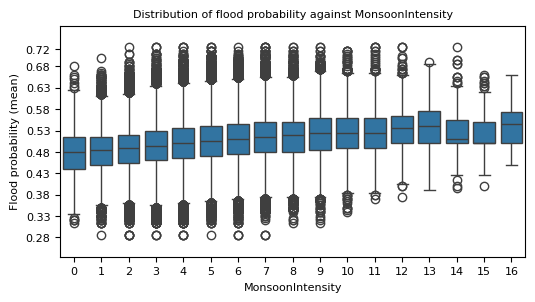

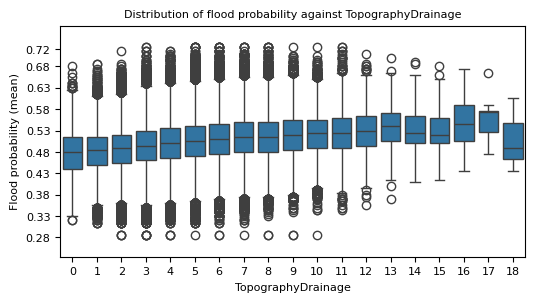

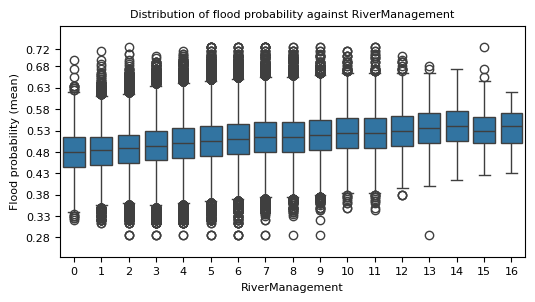

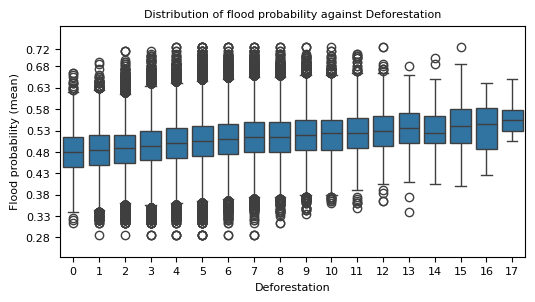

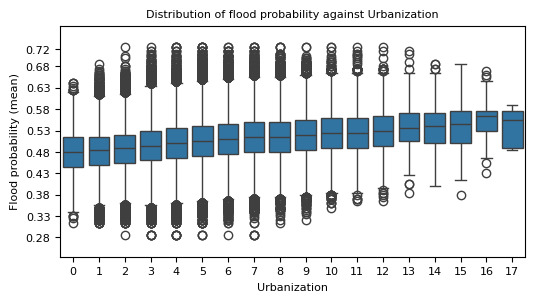

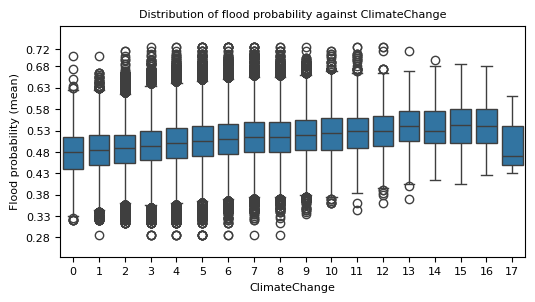

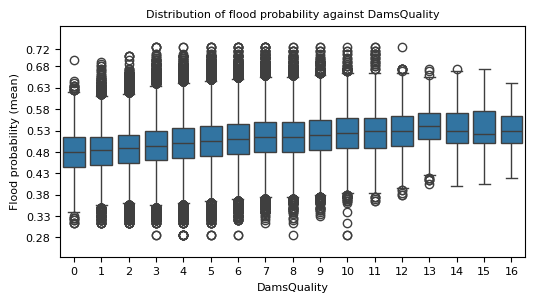

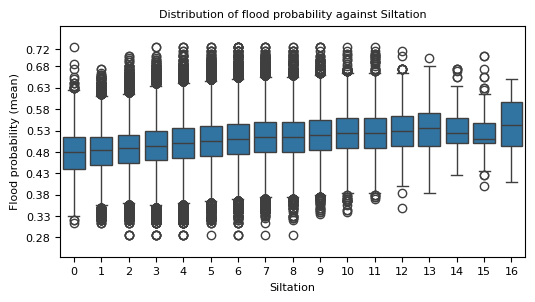

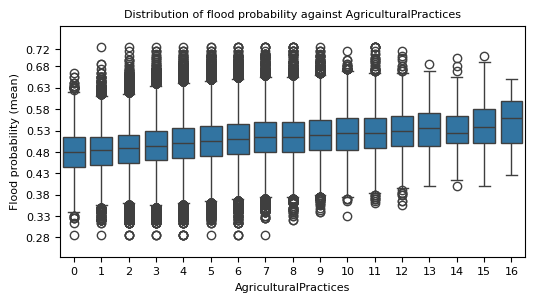

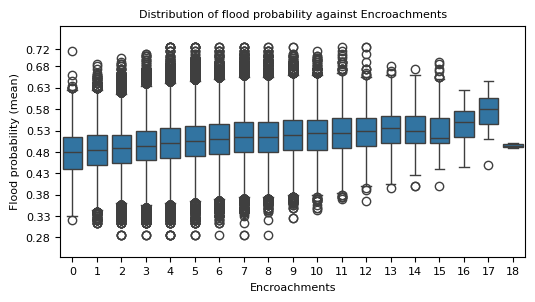

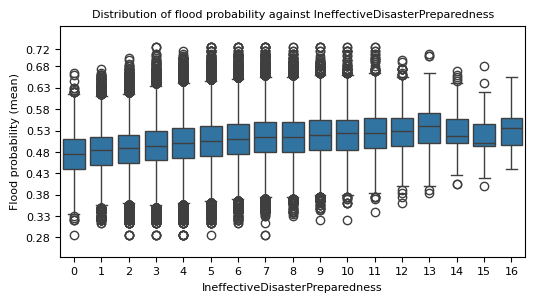

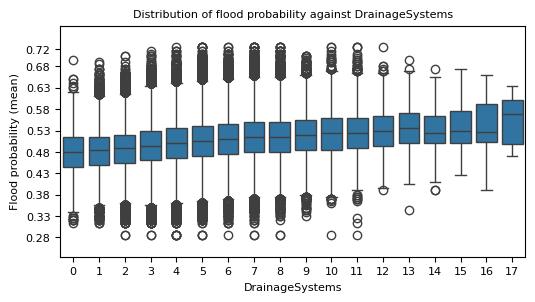

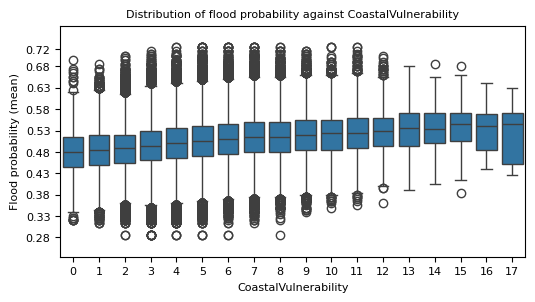

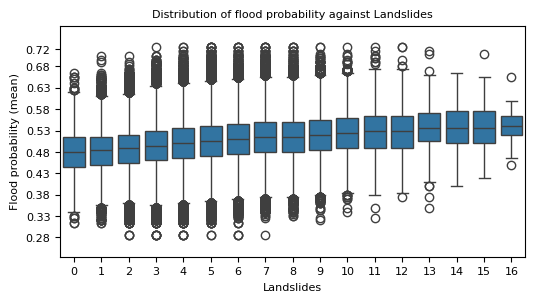

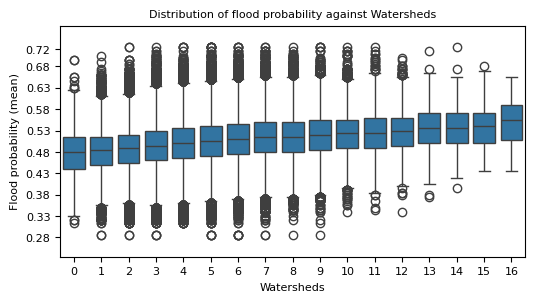

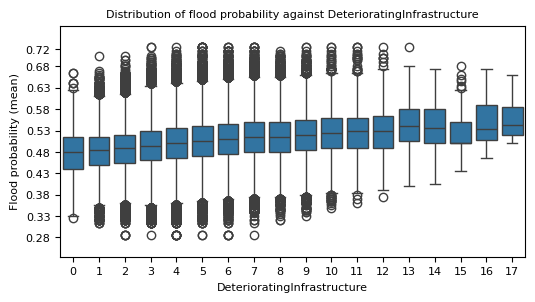

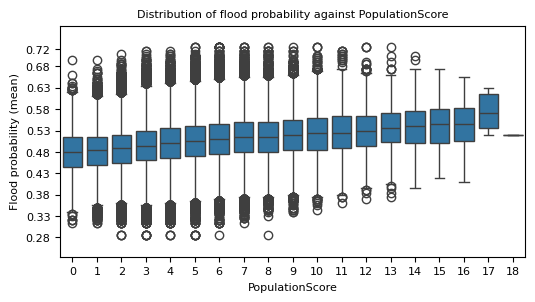

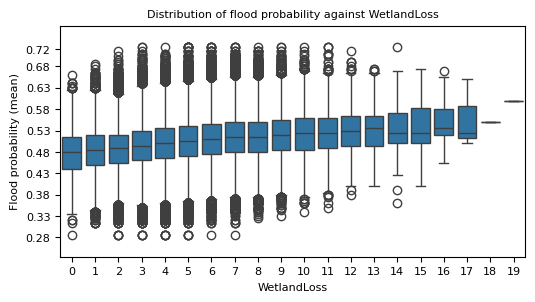

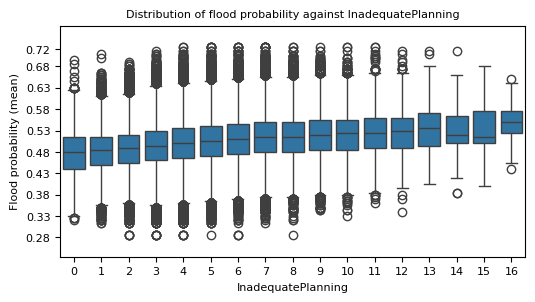

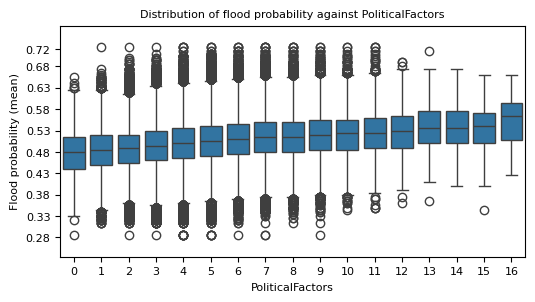

In [45]:
for i in train_df.columns:
    if i in ('id','FloodProbability'):
        pass 
    else:
        plot_boxplots(df=train_df, variable=i)

<u> Notes: </u>

1. There are many outlier flood probabilities across the mid-values of the independent variables
2. Less outliers are found among higher values, but is probably due to low sample size
3. We still see a similar trend of a poorish correlation between the independent variables and median flood probabilities

### Bivariate analysis - between independent variables

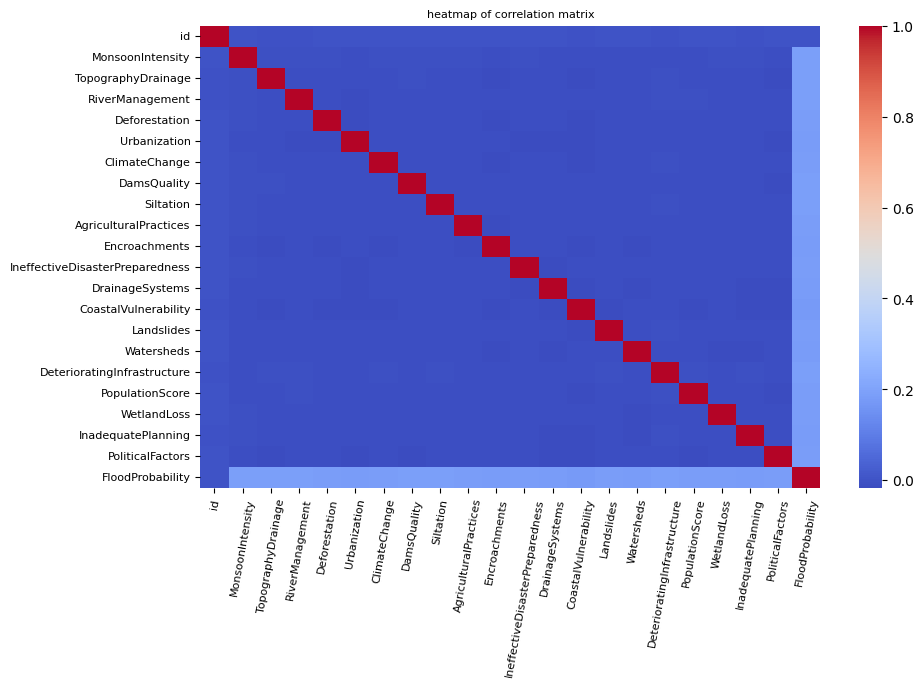

In [46]:
# first half of columns
corr = train_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('heatmap of correlation matrix', fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=80);

<u> Notes: </u>

1. There doesn't seem to be correlations between any of the independent variables, except for correlations between each independent variable and the target variable

### PCA

In [47]:
# pca
X = train_df.columns.tolist()
X.remove('id')
X.remove('FloodProbability')

pca = PCA()

X_pca = pca.fit_transform(train_df[X])

# variance of data explained by principal components
explained_variance_ratio = pca.explained_variance_ratio_

# eigenvectors
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(train_df[X].shape[1])], 
                        index=X)

sorted_loadings = loadings.abs().sort_values(by='PC1', ascending=False)

In [48]:
explained_variance_ratio

array([0.05154727, 0.05151653, 0.05131702, 0.05107014, 0.05102997,
       0.05098338, 0.0508381 , 0.05077164, 0.05069371, 0.05056218,
       0.05051043, 0.0503371 , 0.05025168, 0.05017571, 0.05004197,
       0.04985149, 0.04968824, 0.04946495, 0.04932201, 0.04002649])

In [49]:
k = 5  
top_features_pc1 = sorted_loadings.index.tolist()[:k]
print(f"Top {k} features for PC1:")
print(top_features_pc1)

Top 5 features for PC1:
['TopographyDrainage', 'PoliticalFactors', 'CoastalVulnerability', 'DamsQuality', 'IneffectiveDisasterPreparedness']


In [50]:
sorted_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
TopographyDrainage,0.745429,0.095871,0.523446,0.220574,0.027372,0.051205,0.178215,0.032090,0.070089,0.121235,0.016733,0.023881,0.012273,0.059936,0.041860,0.071006,0.028198,0.058813,0.025728,0.201047
PoliticalFactors,0.555547,0.185714,0.712189,0.025506,0.111839,0.007020,0.037918,0.132181,0.169152,0.125925,0.050950,0.041768,0.048407,0.056517,0.067252,0.002329,0.065923,0.049865,0.038440,0.224415
CoastalVulnerability,0.230425,0.826230,0.128941,0.321190,0.053390,0.041629,0.122629,0.021470,0.170868,0.126320,0.094934,0.020058,0.016102,0.074836,0.020548,0.025139,0.002548,0.020538,0.017253,0.249340
DamsQuality,0.220311,0.025282,0.137111,0.363951,0.063883,0.278899,0.394360,0.580762,0.299234,0.229751,0.119342,0.050292,0.029985,0.099081,0.036763,0.007161,0.110206,0.005473,0.009857,0.203481
IneffectiveDisasterPreparedness,0.089880,0.138938,0.011145,0.004469,0.038471,0.170532,0.370588,0.060119,0.799739,0.064662,0.226210,0.105707,0.121078,0.105146,0.038261,0.033349,0.095032,0.070953,0.044909,0.224679
Encroachments,0.086519,0.387504,0.277965,0.329263,0.181507,0.618766,0.365984,0.013316,0.064042,0.143079,0.106557,0.019236,0.102220,0.012787,0.013791,0.015082,0.007561,0.008991,0.001359,0.243457
Urbanization,0.078283,0.221243,0.234278,0.373780,0.536812,0.561951,0.219981,0.089410,0.028164,0.068908,0.086022,0.040431,0.104320,0.069612,0.015469,0.007315,0.060408,0.010509,0.003626,0.235827
InadequatePlanning,0.054308,0.151501,0.110899,0.047200,0.568856,0.390863,0.339361,0.390871,0.158493,0.054210,0.278693,0.105584,0.138358,0.118589,0.067850,0.032917,0.062827,0.056209,0.022620,0.227741
Siltation,0.048973,0.043076,0.008951,0.029638,0.029842,0.036184,0.009071,0.013934,0.052610,0.023299,0.041899,0.064449,0.325247,0.148847,0.753997,0.459158,0.146702,0.038775,0.088442,0.212053
DrainageSystems,0.046024,0.025909,0.002868,0.008499,0.007080,0.096515,0.048450,0.071911,0.236264,0.838444,0.086729,0.183181,0.154602,0.235936,0.068508,0.115684,0.146611,0.000177,0.041171,0.243981


<u> Notes: </u>

1. Seems like all the principal components contribute roughly equally to the variance, implying no correlations between the independent variables (also verifying the correlation matrix above)
2. Nevertheless, the top 5 features of PC1 are `TopographyDrainage`, `PoliticalFactors`, `CoastalVulnerability`, `DamsQuality` and `IneffectiveDisasterPreparedness`

### [UMAP](#https://umap-learn.readthedocs.io/en/latest/parameters.html)

- UMAP scales faster with bigger datasets than t-SNE, but having a million observations to run it by would still take hours
- To randomly sample n observations across multiple bins of the target variable for faster computation
- `n_neighbors`: Balances between local and global structuring, i.e. how close do we want the similarities to be 
- `min_dist`: Controls how tightly the lower-dimensional points are packed together
- `n_components`: Determines the reduced dimension space the higher-dimensional points are embedded / projected to 
- `metric`: How similarities are calculated

In [191]:
# to append
random_samples = []

# parameters
s = 5000
q = [0,25,50,75,100]

for i in q:
    if i < 100:
        # identify quartiles
        first = np.percentile(train_df['FloodProbability'], i)
        second = np.percentile(train_df['FloodProbability'], i+1)
        # filter 
        subset = train_df[(train_df['FloodProbability'] >= first) & (train_df['FloodProbability'] <= second)]
        # randomly select 
        rows = np.random.choice(subset.index, size=s, replace=False)
        random_samples.extend(rows)
    else:
        pass

assert len(random_samples) == s*(len(q)-1), "mismatched lengths"
assert len(set(random_samples)) == len(random_samples), "duplicate rows"


In [192]:
# filter according to randomly selected rows
random_train_df = train_df.loc[random_samples]

# define labels for continuous target variable for clustering assignment
def syn_labels(
        x: int,
        bins: list = [np.percentile(train_df['FloodProbability'],0),
                      np.percentile(train_df['FloodProbability'],25),
                      np.percentile(train_df['FloodProbability'],50),
                      np.percentile(train_df['FloodProbability'],75),
                      np.percentile(train_df['FloodProbability'],100)]
):
    # filter 
    if (x >= bins[0]) & (x < bins[1]):
        return 'low'
    elif (x >= bins[1]) & (x < bins[2]):
        return 'medium'
    elif (x >= bins[2]) & (x < bins[3]):
        return 'medium-high'
    elif (x >= bins[3]) & (x < bins[4]):
        return 'high'
    else:
        return 'none'

bins = [np.percentile(train_df['FloodProbability'], 0),
        np.percentile(train_df['FloodProbability'], 25),
        np.percentile(train_df['FloodProbability'], 50),
        np.percentile(train_df['FloodProbability'], 75),
        np.percentile(train_df['FloodProbability'], 100)]

# apply
random_train_df['FloodProbability_labels'] = random_train_df['FloodProbability'].apply(lambda x: syn_labels(x, bins=bins))
random_train_df.reset_index(drop=True, inplace=True)
    
# split 
random_train_df_y = random_train_df[['FloodProbability_labels']]
random_train_df_x = random_train_df.drop(columns=['id','FloodProbability_labels','FloodProbability'], axis=1)


In [193]:
random_train_df_y.head(5)

,FloodProbability_labels
0,low
1,low
2,low
3,low
4,low


In [194]:
random_train_df_x.head(5)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,7,4,4,6,2,5,4,3,7,6,3,3,1,3,3,5,4,5,3,1
1,3,2,3,3,5,3,6,1,4,2,8,0,5,8,5,2,2,5,4,7
2,3,3,4,4,3,4,4,4,3,1,3,4,2,5,4,9,2,3,3,3
3,3,2,2,4,6,5,4,4,4,5,3,6,4,6,4,2,3,4,2,3
4,5,2,4,3,5,5,8,4,4,5,3,3,1,5,4,5,2,4,4,2


In [195]:
# umap
import umap 

# grid search
param_grid = {
    'n_neighbors': [5, 10, 15],
    'min_dist': [0.1, 0.4, 0.8],
    'n_components': [2],
    'metric': ['euclidean']
}

umap_est = umap.UMAP(random_state=1)
grid_search = GridSearchCV(estimator=umap_est, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(random_train_df_x)
best_params = grid_search.best_params_


/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -

In [196]:
best_params

{'metric': 'euclidean', 'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5}

In [197]:
# fit with best params 
best_umap_est = umap.UMAP(**best_params)
X_umap = best_umap_est.fit_transform(random_train_df_x)

# trustworthiness score 
tw_score = trustworthiness(random_train_df_x, X_umap, n_neighbors=5)
tw_score


0.6922211249499799

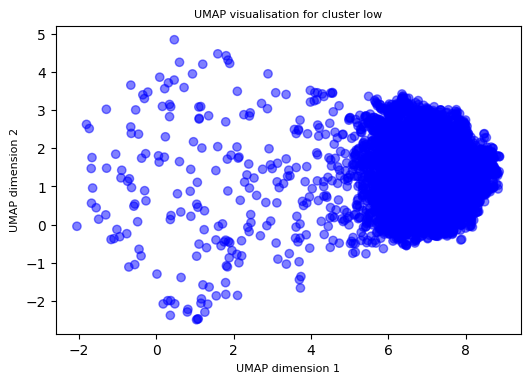

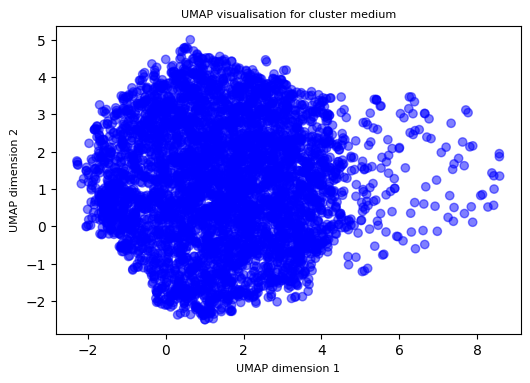

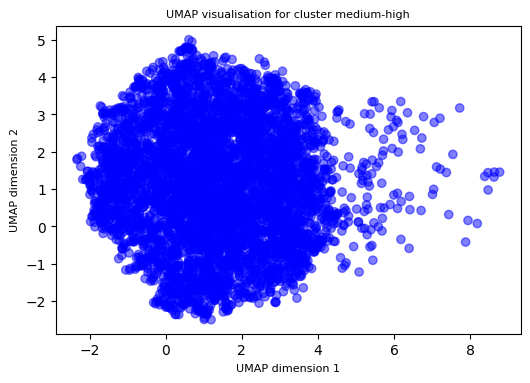

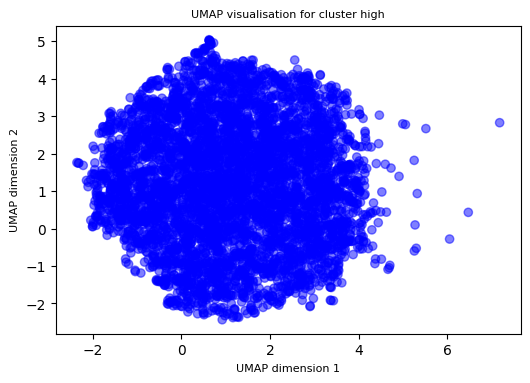

In [211]:
# map colors to target labels 
label_colors = {'low': 0, 'medium': 1, 'medium-high': 2, 'high': 3}
cmap = ListedColormap(['blue', 'cyan', 'magenta', 'red'])

# plot per cluster in case of overlaps 
for k,v in label_colors.items():
    # filter df to each probability label
    cluster_random_train_df_y = random_train_df_y[random_train_df_y['FloodProbability_labels']==k]
    # get index
    cluster_index = cluster_random_train_df_y.index.tolist()
    # use index to get correct UMAP coordinates
    X_umap_cluster_coord1 = X_umap[cluster_index, 0] 
    X_umap_cluster_coord2 = X_umap[cluster_index, 1] 
    # map colors 
    map_colors = cluster_random_train_df_y['FloodProbability_labels'].map(label_colors)
    # plot
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(X_umap_cluster_coord1, X_umap_cluster_coord2, c=map_colors, cmap=cmap, alpha=0.5)
    # plt.colorbar(scatter, ticks=[0, 1, 2, 3], format=plt.FuncFormatter(lambda val, loc: ['low', 'medium', 'medium-high', 'high'][int(val)]))
    plt.title(f"UMAP visualisation for cluster {k}", fontsize=8)
    plt.xlabel('UMAP dimension 1', fontsize=8)
    plt.ylabel('UMAP dimension 2', fontsize=8)
    plt.show()
    

<u> Notes: </u>

1. There seems to be major overlaps in the medium, medium-high and high flood probability clusters (to the right).
2. Only the low cluster is separated from the rest (to the left).
3. Datapoints of the low cluster tend to have a narrower range of dimension 2's coordinates (y-axis) as compared with the other clusters.
4. Another observation also is its concentration of higher dimension 1's coordinates (x-axis). 
5. All these meaning to say that there are uniquely, distinctive properties to the low cluster, while the other clusters probably share more similar properties with each other. 

### Finding features that are unique to the low cluster

- ANOVA between the categorical clusters and each feature 
- Spearman's between UMAP dimension 1 coordinates and each feature (seeing as the low cluster has the highest concentration of the higher values of dimension 1)

In [214]:
train_df_copy = train_df.copy()

train_df_copy['FloodProbability_labels'] = train_df_copy['FloodProbability'].apply(lambda x: syn_labels(x, bins=bins))

train_df_copy['FloodProbability_labels'].value_counts()


FloodProbability_labels
high           291677
medium         285437
medium-high    277728
low            263086
none               29
Name: count, dtype: int64

In [215]:
train_df_copy.groupby('FloodProbability_labels')['FloodProbability'].min()

FloodProbability_labels
high           0.540
low            0.285
medium         0.470
medium-high    0.505
none           0.725
Name: FloodProbability, dtype: float64

In [217]:
train_df_copy.groupby('FloodProbability_labels')['FloodProbability'].max()

FloodProbability_labels
high           0.715
low            0.465
medium         0.500
medium-high    0.535
none           0.725
Name: FloodProbability, dtype: float64

In [218]:
train_df_copy['FloodProbability_labels'] = train_df_copy['FloodProbability_labels'].replace('none','high')

train_df_copy['FloodProbability_labels'].value_counts()

FloodProbability_labels
high           291706
medium         285437
medium-high    277728
low            263086
Name: count, dtype: int64

In [224]:
train_df_copy.columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability',
       'FloodProbability_labels'],
      dtype='object')

In [226]:
train_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 23 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [225]:
# anova
model = ols('FloodProbability_labels ~ C(MonsoonIntensity)', data=train_df_copy).fit() 
anova_results = sm.stats.anova_lm(model, typ=2)

ValueError: endog has evaluated to an array with multiple columns that has shape (1117957, 4). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

---